In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import slim
from tensorflow.contrib import distributions

In [2]:
BATCH_SIZE = 500
D_LR = 1e-4
G_LR = 2e-4

In [3]:
# specify mixture model to be learned
# this is the target distribution

mixture_model = {'n_components':3,
                 'weights':[.2,.2,.6],
                 'means':[[-2.5],[-.5],[2.]],
                 'sds':[[.15],[.2],[.3]]
                }

def mixture_pdf(model):
    dist = distributions.MixtureSameFamily(
        mixture_distribution=distributions.Categorical(
            probs=model['weights']),
        components_distribution=distributions.MultivariateNormalDiag(
            loc=model['means'],       # One for each component.
            scale_diag=model['sds']))  # And same here.
    return dist.prob

mixprob = mixture_pdf(mixture_model)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [4]:
# specify the generator that will learn this mixture model

initial_model = {'n_components':3,
                 'n_dims':1,
                 'weights':[1./3,1./3,1./3],
                 'means':[[-2],[0.],[2]],
                 'sds':[[.5],[.5],[.5]]
                }

def generator(eps_unif,eps_gauss,tau=.001,n_layers=3,reuse=False):
    """
    Use random noise 'eps' to sample from mixture model
    """
    with tf.variable_scope("generator", reuse=reuse) as scope:
        
        means = slim.model_variable('means',
                                    shape=np.shape(initial_model['means']),
                                    initializer=tf.constant_initializer(initial_model['means'])
                                   )
        
        sds = slim.model_variable('sds',
                                  shape=np.shape(initial_model['sds']),
                                  initializer=tf.constant_initializer(initial_model['sds'])
                                 )
        
        slim.stack(eps_unif, slim.fully_connected, 
                   [10,10,initial_model['n_components']], 
                   activation_fn=tf.nn.elu, 
                   scope='fc'
                  )
        
        weights = slim.softmax(eps_unif/tau)
        
        y = tf.reduce_sum(weights[:,:,tf.newaxis] * means[tf.newaxis,:,:], axis=1)
        y += tf.reduce_sum(weights[:,:,tf.newaxis] * sds[tf.newaxis,:,:],axis=1) * eps_gauss
        
        return y

eps_unif = tf.random_uniform((BATCH_SIZE,initial_model['n_components']),dtype=tf.float32)
eps_gauss = tf.random_normal((BATCH_SIZE,initial_model['n_dims']),dtype=tf.float32)

y = generator(eps_unif,eps_gauss)

In [5]:
# specify the reference distribution. we need to both evaluate and sample

ref = distributions.MultivariateNormalDiag(
    loc=[0.],
    scale_diag=[2.5]
)

reflogprob = ref.log_prob
refsample = ref.sample(sample_shape=BATCH_SIZE)

In [6]:
# specify the adversary, which will learn the likelihood ratio
# between generator samples and reference samples

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def adversary(y, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse) as scope:
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(y, 256, scope='fc_0')

            for i in range(5):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, 1, activation_fn=None, scope='T',
                                weights_initializer=tf.constant_initializer(0.))
        T = tf.squeeze(T, [1])
        return T

In [7]:
# prepare for run

dref = adversary(refsample)
dy = adversary(y,reuse=True)

dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "adversary")
gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")

dloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=dy, labels=tf.ones_like(dy))
    + tf.nn.sigmoid_cross_entropy_with_logits(logits=dref, labels=tf.zeros_like(dref))
)

gloss = tf.reduce_sum(reflogprob(y) - tf.log(mixprob(y)) + dy, axis=0)

dtrain_step = tf.train.AdamOptimizer(D_LR).minimize(dloss,var_list=dvars)
gtrain_step = tf.train.AdamOptimizer(G_LR).minimize(gloss,var_list=gvars)

In [30]:
from tqdm import tqdm_notebook, tnrange

def run_training(sess, niter=10000):
    
    # consider a burn-in period for the discriminator before going to the generator

    progress = tqdm_notebook(range(niter))

    for i in progress:
              
        y_,refsample_,dref_,dy_,dloss_,_ = s.run([y,refsample,dref,dy,dloss,dtrain_step])
        _ = s.run([gtrain_step])
            
        progress.set_description("dloss=%.3f"  % (dloss_))
        
        if i%500 == 0:
            fig,ax=plt.subplots(1,2,figsize=(10,5))
            ax[0].scatter(y_,dy_,alpha=.3)
            ax[0].scatter(refsample_,dref_,alpha=.3)
            ax[0].set_xlim([-4,4])
            ax[0].set_ylim([-20,5])
            ax[1].hist(y_,50,alpha=.3,normed=True)
            ax[1].hist(refsample_,50,alpha=.3,normed=True)
            for pair in zip(mixture_model['means'],mixture_model['sds'],mixture_model['weights']):
                ax[1].plot([pair[0][0]-pair[1][0],pair[0][0]+pair[1][0]],[-.015,-.015],'-',linewidth=5*pair[2]/pair[1][0])
            ax[1].set_xlim([-4,4])
            plt.savefig('out_mix/iter_%i.png' % i)

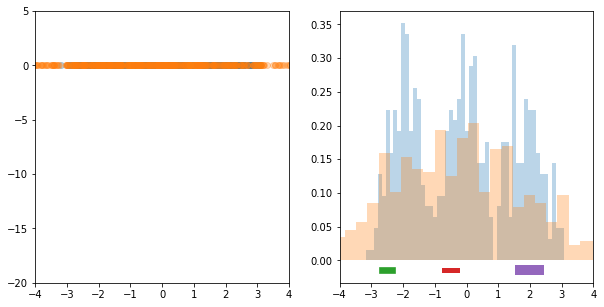

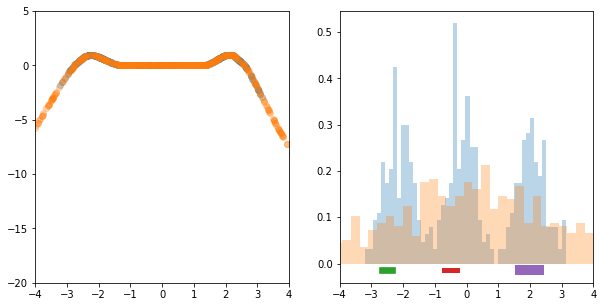

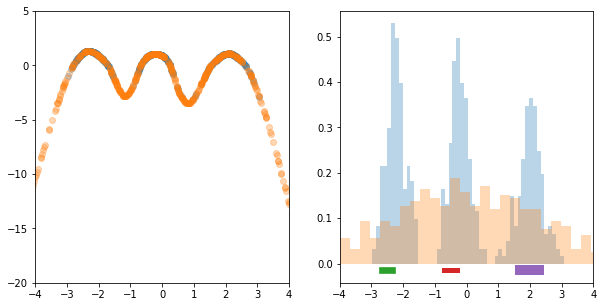

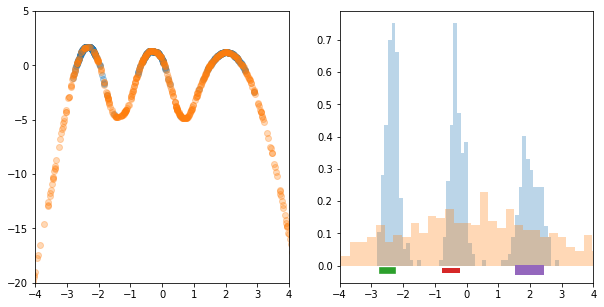

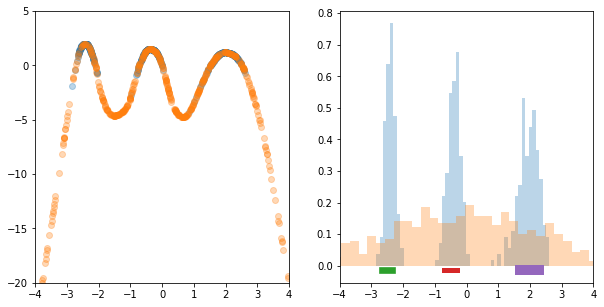

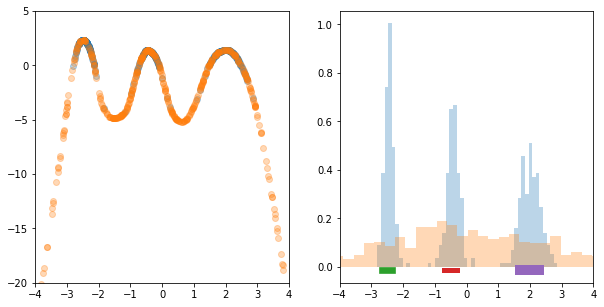

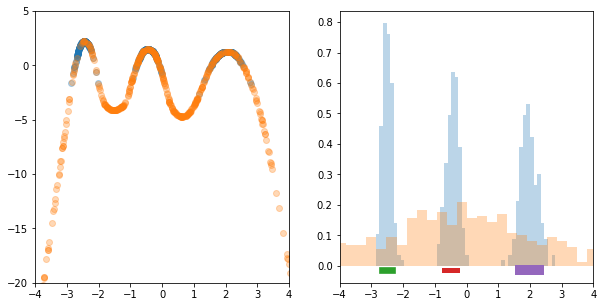

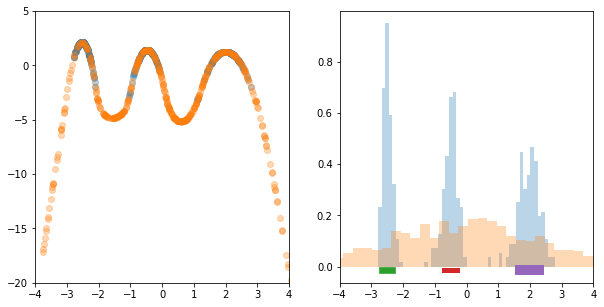

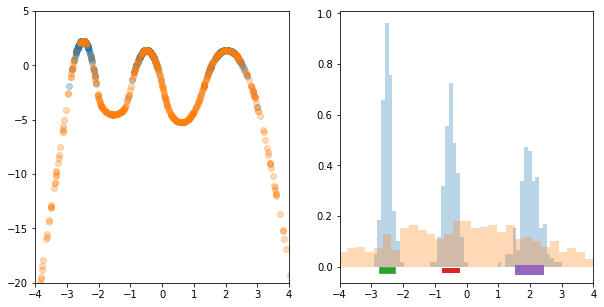

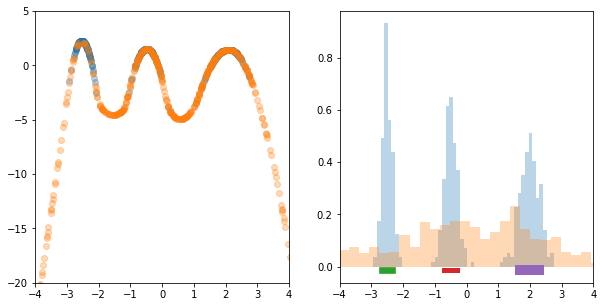

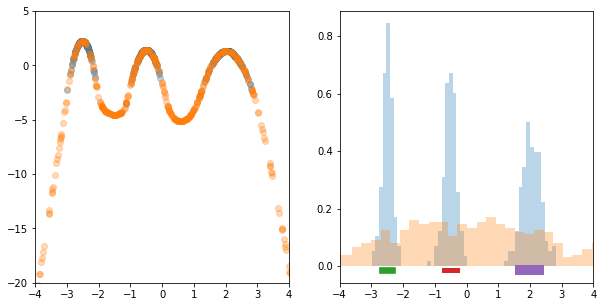

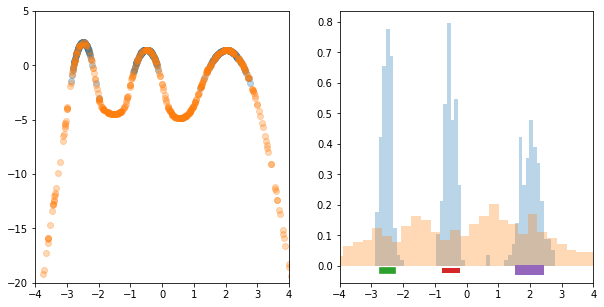

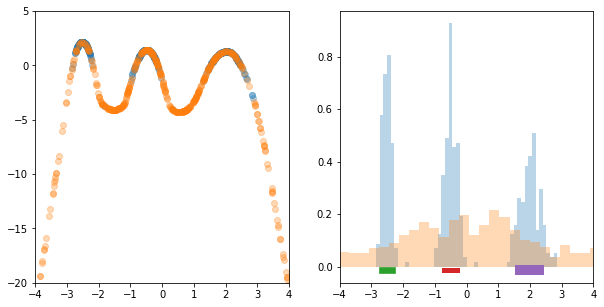

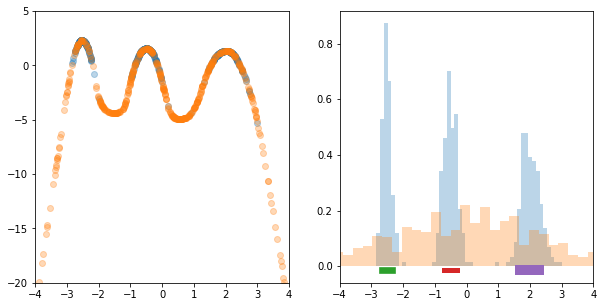

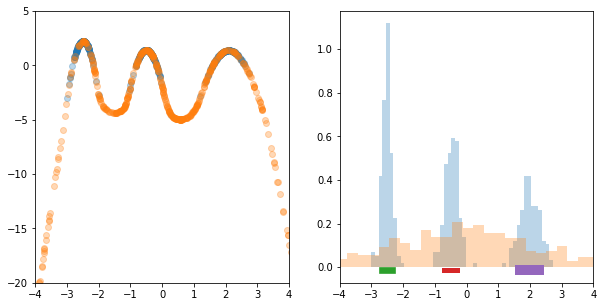

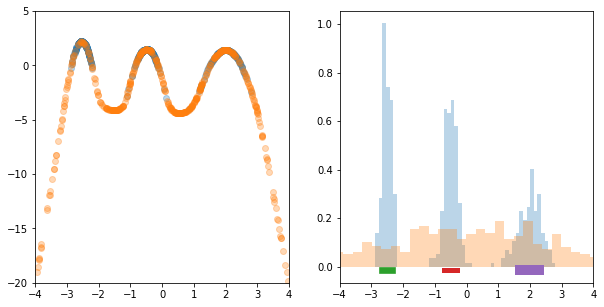

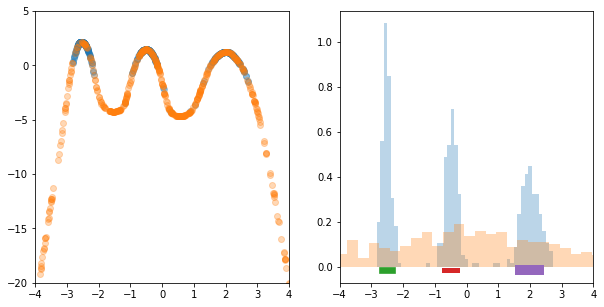

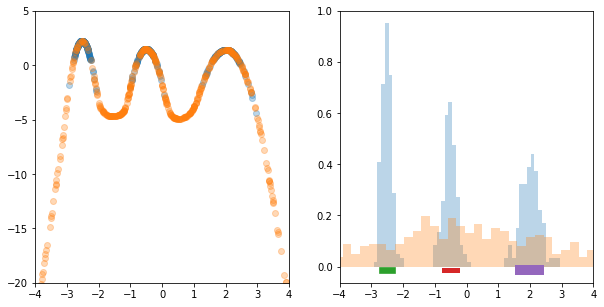

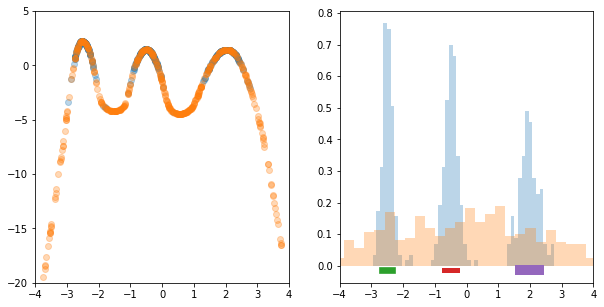

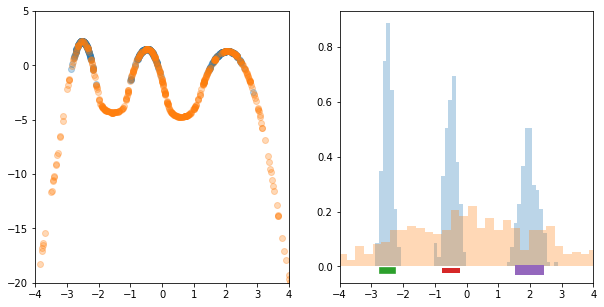

In [31]:
import os
outdir = './out_mix'
if not os.path.exists(outdir):
    os.makedirs(outdir)

try:
    s.close()
except NameError:
    pass
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())
run_training(s,niter=10000)

In [10]:
for pair in zip(mixture_model['means'],mixture_model['sds']):
    print(pair)

([-2.5], [0.15])
([-0.5], [0.2])
([2.0], [0.3])
